<a href="https://colab.research.google.com/github/dsevero/dsevero.com/blob/master/notebooks/On_Distributed_Quantization_for_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from toolz import pipe
from collections import defaultdict
from itertools import product
from joblib import Parallel, delayed
import multiprocessing
CPU_COUNT = multiprocessing.cpu_count()

colors_hex = ['#FF0000', '#0000FF']
cm_bright = ListedColormap(colors_hex)

parallel = Parallel(n_jobs=CPU_COUNT, verbose=10)

# 1. On-the-line quantizer

## 1.1 Generate data

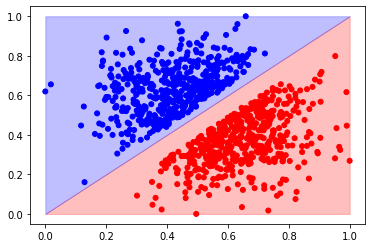

In [100]:
def _data_fixture():
    X = np.array([*[[0.2*i + 0.1, 0.2*(i+1)] for i in range(1, 5)],
                  *[[0.2*i + 0.1, 0.2*(i-1)] for i in range(1, 5)]])
    y = (X[:, 0] < X[:, 1]).astype(int)    
    return X, y

def normalize(X):
    x = X - X.min(axis=0)
    return x/x.max(axis=0)

def generate_data(N, separation=.25, seed=None):
    X = np.random.RandomState(seed).normal(size=(N, 2))
    y = (X[:, 0] < X[:, 1]).astype(int)
    X[y == 1, 0] -= separation
    X[y == 1, 1] += separation
    X[y == 0, 0] += separation
    X[y == 0, 1] -= separation
    X = normalize(X)
    y = (X[:, 0] < X[:, 1]).astype(int)
    return X, y

def make_potential_boundaries(X):
    return pipe(X, np.ravel, np.unique, np.sort)

def plot(X, y, boundaries=None, **plot_kwargs):
    fig, ax = plt.subplots(**plot_kwargs)
    ax.scatter(*X.T, c=y, s=25, cmap=cm_bright)
    x = np.linspace(0, 1, 100)
    ax.fill_between(x, x, 0, alpha=0.25, color=colors_hex[0])
    ax.fill_between(x, x, 1, alpha=0.25, color=colors_hex[1])

    if boundaries is not None:
        for b in boundaries:
            ax.vlines(b, 0, 1, linestyles='dashed')
            ax.hlines(b, 0, 1, linestyles='dashed')

    return fig, ax

X, y = generate_data(1000)
plot(X, y);

## 1.2 Algorithm

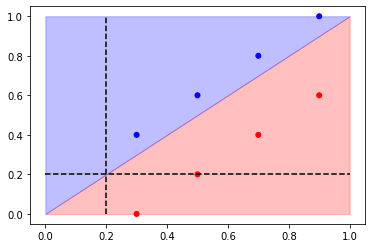

In [10]:
def _min_gap_error(X, y, si, sl=-1):
    mask = ((X > sl) & (X <= si)).all(axis=1)
    return min(((y == c) & mask).sum() for c in [0, 1])

def ontheline_quantizer(X, y, R):
    s = make_potential_boundaries(X)
    E = np.zeros((len(s), 2**R))
    A = defaultdict(lambda: defaultdict(set))
    for i, si in enumerate(s):
        E[i, 0] = _min_gap_error(X, y, si)

    for i, si in enumerate(s):
        for b in range(1, 2**R):
            if i == 0:
                E[i, b] = 0
                A[i][b] = set()
            else:
                (E[i, b],
                 l_star,
                 sl_star) = min([E[l, b-1] + _min_gap_error(X, y, si, sl), l, sl]
                                for l, sl in enumerate(s[:i]))
                A[i][b] = A[l_star][b-1].union({sl_star})

    return E, A, A[len(s)-1][2**R-1]

X, y = _data_fixture()
E, A, d = ontheline_quantizer(X, y, 1)
plot(X, y, d);

## 1.3 Sanity Checks

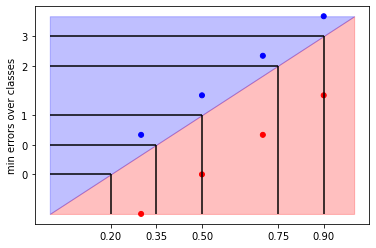

In [11]:
def test_zero_boundaries():
    X, y = _data_fixture()
    plot(X, y);
    boundaries = [0.20, 0.35, 0.50, 0.75, 0.90]
    errors = [0, 0, 1, 2, 3]
    for b, e in zip(boundaries, errors):
        assert _min_gap_error(X, y, b) == e
        plt.vlines(b, 0, b, linestyles='solid')
        plt.hlines(b, 0, b, linestyles='solid')
        plt.xticks(boundaries)
        plt.yticks(boundaries, labels=[f'{e}' for e in errors])
        plt.ylabel('min errors over classes')

test_zero_boundaries()

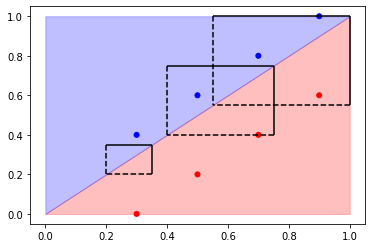

In [12]:
def draw_square(*edges):
    plt.vlines(edges[0], edges[0], edges[1], linestyles='solid')
    plt.vlines(edges[1], edges[0], edges[1], linestyles='dashed')
    plt.hlines(edges[0], edges[0], edges[1], linestyles='solid')
    plt.hlines(edges[1], edges[0], edges[1], linestyles='dashed')

def test_gap_boundaries():
    X, y = _data_fixture()
    plot(X, y);
    gaps = [(.35, .20), (.75, .40), (1.0, .55)]
    errors = [0, 0, 1]
    for g, e in zip(gaps, errors):
        assert _min_gap_error(X, y, *g) == e
        draw_square(*g)

test_gap_boundaries()

## 1.4 Run on separable data

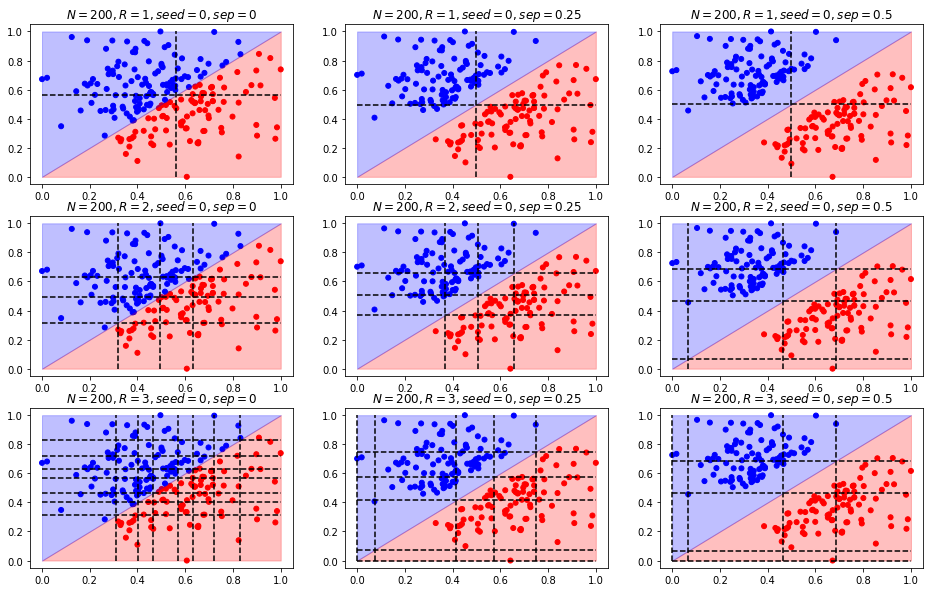

In [13]:
N = 200
seed = 0
R_space = [1, 2, 3]
sep_space = [0, 0.25, 0.5]

plt.figure(figsize=(16,10))
metrics = list()
for i, (R, separation) in enumerate(product(R_space, sep_space), 1):
    X, y = generate_data(N, separation, seed)
    E, A, boundaries = ontheline_quantizer(X, y, R)
    plt.subplot(3, 3, i)

    plt.scatter(*X.T, c=y, s=25, cmap=cm_bright)
    x = np.linspace(0, 1, 100)
    plt.fill_between(x, x, 0, alpha=0.25, color=colors_hex[0])
    plt.fill_between(x, x, 1, alpha=0.25, color=colors_hex[1])

    for b in boundaries:
        plt.vlines(b, 0, 1, linestyles='dashed')
        plt.hlines(b, 0, 1, linestyles='dashed')
    
    plt.title(f'$N={N}, R={R}, seed={seed}, sep={separation}$')

    metrics.append({'loss': E[-1][-1]/N,
                    'R': R,
                    'separation': separation})

## 1.5 Does separation make the problem easier?

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    8.8s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   18.3s
[Parallel(n_jobs=8)]: Done  19 out of  30 | elapsed:  1.3min remaining:   45.2s
[Parallel(n_jobs=8)]: Done  23 out of  30 | elapsed:  2.3min remaining:   42.8s
[Parallel(n_jobs=8)]: Done  27 out of  30 | elapsed:  2.7min remaining:   17.7s
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:  3.2min finished


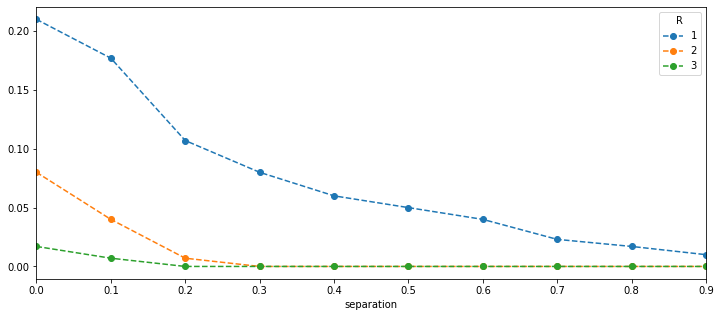

In [15]:
N = 300
seed = 0
R_space = [1, 2, 3]
sep_space = np.arange(0, 1, 0.1)

@delayed
def single_run(R, separation):
    X, y = generate_data(N, separation, seed)
    E, _, _ = ontheline_quantizer(X, y, R)
    return {'loss': E[-1][-1]/N,
             'R': R,
             'separation': separation}

metrics = parallel(single_run(R, s) for R, s in product(R_space, sep_space))

(pd
 .DataFrame(metrics)
 .round(3)
 .pivot('separation', 'R', 'loss')
 .plot(style='o--', figsize=(12,5)));

## 1.6 Boundary quantization

3 (300, 2) [0.48087875 0.39355623] 0 (78, 2, <ufunc 'greater'>, 1) (94,)
2 (94, 2) [0.35968603 0.18988336] 0 (76, 2, <ufunc 'greater'>, 1) (92,)
1 (92, 2) [0.36989916 0.87492501] 1 (60, 2, <ufunc 'greater'>, 1) (71,)


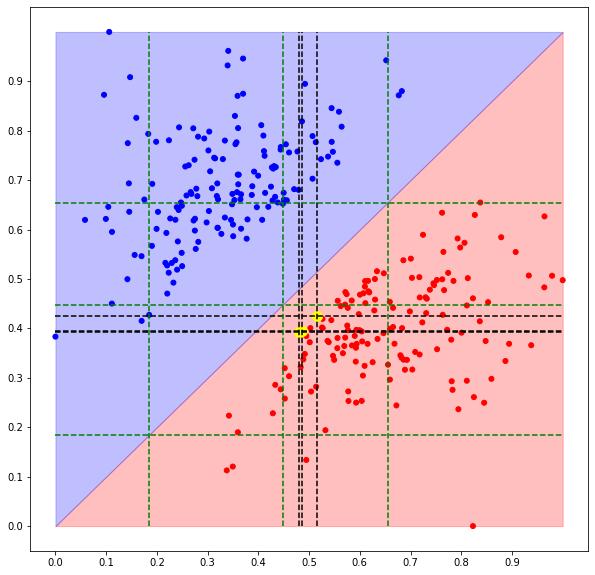

In [569]:
from matplotlib.colors import BASE_COLORS
seed = None
X, y = generate_data(N, separation, seed)

def rotate(X, angle=np.pi/4):
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    return X.dot(R.T)

RX = rotate(X)
plot(X, y, figsize=(10, 10));
plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0, 1, 0.1))

def nearestToBoundary_quantizer(mask=None, depth=5, boundaries=[]):
    mask = np.arange(y.shape[0]) if mask is None else mask
    i = np.abs(RX[mask, 0]).argmin()
    d = X[mask][i, :]

    plt.scatter(*d, c='yellow', s=100);
    plt.vlines(d[0], 0, 1, linestyles='dashed');
    plt.hlines(d[1], 0, 1, linestyles='dashed');
    
    max_error = max(((y[mask][f(X[mask], d).all(axis=1)] != c).sum(), i, f, c)
                    for i, (c, f) in enumerate(product([0, 1], [np.greater, np.less])))

    _, _, f, c = max_error
    new_mask = mask[f(X[mask], d).all(axis=1)]
    print(depth,X[mask].shape, X[i], y[i], max_error, new_mask.shape)
    # plt.scatter(*X[new_mask].T, c=list(BASE_COLORS.keys())[-depth])
    if depth > 1:
        algorithm(new_mask, depth-1, boundaries+[d])

nearestToBoundary_quantizer(depth=3)
E, A, boundaries = ontheline_quantizer(X, y, 2)
for b in boundaries:
    plt.vlines(b, 0, 1, 'green', linestyles='dashed')
    plt.hlines(b, 0, 1, 'green', linestyles='dashed')

In [0]:
assert np.isclose(np.eye(2).dot(R.T).dot(R.T), [[0, 1],[-1, 0]]).all()

# Questions
1. On-the-line quantizer minimizes reconstruction error, but does it minimize risk?

2. What if we perform block coding?